In [1]:
import pandas as pd
import csv
import sqlite3
from matplotlib import pyplot as plt
import numpy as np

In [2]:
#My initial dataset was 123MB and a file that big can not be pushed to github. I had to create a selection specifically stats
#for the US and read them into a separate file for inclusion on Github. The commented out code below is the code I used
#to create my new file

#energy = pd.read_csv('all_energy_statistics.csv')

#energy.dropna()

#US_energy = energy['country_or_area'] == 'United States'

#test = energy[US_energy]

#test.to_csv(r'US_energy.csv', index = False)

USA_energy = pd.read_csv('US_energy.csv')

USA_energy

,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,United States,Additives and Oxygenates - Exports,2014,"Metric tons, thousand",2484.0,NaN,additives_and_oxygenates
1,United States,Additives and Oxygenates - Exports,2013,"Metric tons, thousand",2640.0,NaN,additives_and_oxygenates
2,United States,Additives and Oxygenates - Exports,2012,"Metric tons, thousand",2579.0,NaN,additives_and_oxygenates
3,United States,Additives and Oxygenates - Exports,2011,"Metric tons, thousand",2506.0,NaN,additives_and_oxygenates
4,United States,Additives and Oxygenates - Exports,2010,"Metric tons, thousand",2497.0,NaN,additives_and_oxygenates
...,...,...,...,...,...,...,...
19842,United States,Electricity - total wind production,1994,"Kilowatt-hours, million",3483.0,NaN,wind_electricity
19843,United States,Electricity - total wind production,1993,"Kilowatt-hours, million",3053.0,NaN,wind_electricity
19844,United States,Electricity - total wind production,1992,"Kilowatt-hours, million",2917.0,NaN,wind_electricity
19845,United States,Electricity - total wind production,1991,"Kilowatt-hours, million",3051.0,NaN,wind_electricity


In [4]:
db = sqlite3.connect("Energy.db")

USA_energy.to_sql("Energy", db, if_exists="replace")

query = 'SELECT * FROM Energy WHERE country_or_area="United States" AND category="wind_electricity";'

results = pd.read_sql_query(query, db)

results

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,19822,United States,Electricity - total wind production,2014,"Kilowatt-hours, million",183892.0,None,wind_electricity
1,19823,United States,Electricity - total wind production,2013,"Kilowatt-hours, million",169713.0,None,wind_electricity
2,19824,United States,Electricity - total wind production,2012,"Kilowatt-hours, million",141922.0,None,wind_electricity
3,19825,United States,Electricity - total wind production,2011,"Kilowatt-hours, million",120854.0,None,wind_electricity
4,19826,United States,Electricity - total wind production,2010,"Kilowatt-hours, million",95148.0,None,wind_electricity
5,19827,United States,Electricity - total wind production,2009,"Kilowatt-hours, million",74226.0,None,wind_electricity
6,19828,United States,Electricity - total wind production,2008,"Kilowatt-hours, million",55696.0,None,wind_electricity
7,19829,United States,Electricity - total wind production,2007,"Kilowatt-hours, million",34603.0,None,wind_electricity
8,19830,United States,Electricity - total wind production,2006,"Kilowatt-hours, million",26676.0,None,wind_electricity
9,19831,United States,Electricity - total wind production,2005,"Kilowatt-hours, million",17881.0,None,wind_electricity


Text(0.5, 1.0, 'Kilowatt-hours of wind energy produced by year')

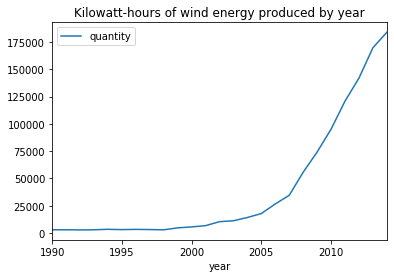

In [7]:
results.plot(x='year', y='quantity')

plt.title("Kilowatt-hours of wind energy produced by year")